TISSOT-FAVRE Pierre-Louis, TRAN VAN LIEU Romain, VABRET Dimitri

In [ ]:
!pip install pycryptodome gmpy2 matplotlib

# utils.py

In [ ]:
from Crypto.PublicKey import DSA
from Crypto.Hash import SHA256
from Crypto.Signature import DSS

def string_to_bytes(str: str):
  return bytes(str, 'utf-8')

def bytes_to_string(b):
  return b.decode("utf-8")

def int_to_bytes(n):
  return n.to_bytes((n.bit_length() + 7) // 8, 'big')

def bytes_to_int(nb):
  return int.from_bytes(nb, 'big')

def string_to_int(str: str):
  return bytes_to_int(string_to_bytes(str))

def int_to_string(n):
  return bytes_to_string(int_to_bytes(n))

def sign_message(key, bytes_message):
  hash_obj = SHA256.new(bytes_message)
  signer = DSS.new(key, 'fips-186-3')
  return signer.sign(hash_obj)

def verify_signature(public_key_filename, bytes_message, signature):
  with open(public_key_filename, "r") as f:
    public_key = DSA.importKey(f.read())
  hash_obj = SHA256.new(bytes_message)
  verifier = DSS.new(public_key, 'fips-186-3')
  verifier.verify(hash_obj, signature)

# 1 Paillier Cryptosystem

### pallier.py

In [ ]:
import random
from gmpy2 import mpz, gcd, invert, next_prime

class Paillier:
    def __init__(self, bits):
        self.keyGen(bits)

    def keyGen(self, bits):
        while True:
           # Generate prime numbers p and q of nb bits bits each, ensuring they have the same bit length
            p = next_prime(random.getrandbits(bits))
            q = next_prime(random.getrandbits(bits))
            if p == q:
                continue
                # They must satisfy : gcd(p·q, (p−1)·(q−1)) = 1
            if gcd(p * q, (p - 1) * (q - 1)) == 1:
                break
                # Compute n = p·q, g = n+1, lam = (p−1)·(q−1) and mu = lam^(−1) mod n
        n = p * q
        g = n + 1
        lam = (p - 1) * (q - 1)
        mu = invert(lam, n)

        self.n = n
        self.g = g
        self.lambda_ = lam
        self.mu = mu
         # Output the public key pk = (n, g) and the private key sk = (lamda, mu)
        self.pk = (n, g)
        self.sk = (lam, mu)

    def encrypt(self, message: int):
        # Ensure that 0 ≤ m < n (message must be smaller than n)
        if not (0 <= message < self.n):
            raise ValueError("Message must be in range 0 <= m < n")

        # Generate a random r such that 0 < r < n and gcd(r, n) = 1
        r = random.randint(1, self.n - 1)
        while gcd(r, self.n) != 1:
            r = random.randint(1, self.n - 1)
            # Compute the ciphertext: c = g^m · r^n mod n^2
        return (pow(self.g, message, self.n ** 2) * pow(r, self.n, self.n ** 2)) % (self.n ** 2)

    def decrypt(self, ciphertext: int):
        if not (0 <= ciphertext < self.n ** 2):
            raise ValueError("Ciphertext out of range")
        # L(c^lamda mod n^2) = ((c^lamda mod n^2) - 1) / n
        L = (pow(ciphertext, self.lambda_, self.n ** 2) - 1) // self.n
        # m = (L(c^lamda mod n^2) * mu) / n
        return (L * self.mu) % self.n

# Test block
if __name__ == "__main__":
  # Create a Paillier instance with a small key size for testing
  paillier = Paillier(bits=128)
  n, g = paillier.pk
  n_squared = n ** 2

  # Test messages
  m1 = 5
  m2 = 7

  # Encryption
  c1 = paillier.encrypt(m1)
  c2 = paillier.encrypt(m2)
  print("m1:", m1)
  print("m2:", m2)
  print("Encrypted m1:", c1)
  print("Encrypted m2:", c2)

  # Test 2 — Homomorphic addition: Enc(m1) * Enc(m2) = Enc(m1 + m2)
  c_add = (c1 * c2) % n_squared
  dec_add = paillier.decrypt(c_add)
  print("Decryption of Enc(m1) * Enc(m2):", dec_add)
  assert dec_add == m1 + m2

  # Test 3 — Addition with a plaintext message: Enc(m1) * g^m2 = Enc(m1 + m2)
  c_add_plain = (c1 * pow(g, m2, n_squared)) % n_squared
  dec_add_plain = paillier.decrypt(c_add_plain)
  print("Decryption of Enc(m1) * g^m2:", dec_add_plain)
  assert dec_add_plain == m1 + m2

  # Test 4 — Multiplication by a constant: Enc(m1)^m2 = Enc(m1 * m2)
  c_mult_const = pow(c1, m2, n_squared)
  dec_mult_const = paillier.decrypt(c_mult_const)
  print("Decryption of Enc(m1)^m2:", dec_mult_const)
  assert dec_mult_const == m1 * m2

m1: 5
m2: 7
Encrypted m1: 4536917656400894793137707014514831682805832914442220835681312896174394715715792874896506329129810112536650156214033991515173067702316293734402827064966
Encrypted m2: 6345056235117513354866117547135848543849021286310717869969610610576079320088239259430166274881294950864233946828427557319745395749673870278913000296460
Decryption of Enc(m1) * Enc(m2): 12
Decryption of Enc(m1) * g^m2: 12
Decryption of Enc(m1)^m2: 35


# 2 PIR Protocol

### 1. How to homomorphically compute the value of t? Describe the necessary operations.
To compute t homomorphically, the server raises each encrypted query entry v[j] to the power of T[j], and multiplies all results modulo n². Thanks to Paillier's homomorphic properties, only the encrypted value at position i contributes, resulting in Enc(T[i]).
[22:59]


### 2.  Which value does the client retrieve after decrypting the answer from the server?
The client retrieves the plaintext value T[i] corresponding to the index he queried. This value is obtained by decrypting the server's answer using the Paillier private key.

### client.py

In [ ]:
class Client:
  # The constructor which generates the Paillier cryptosystem associated with the client, for a number of bits given as input to the constructor.
  def __init__(self, bits=512):
    self.paillier = Paillier(bits)
    self.pk = self.paillier.pk
    self.sk = self.paillier.sk

  def request(self, index, n):
    # The client wishes to retrieve the element of index i in T from the server. For this,
    # the client generates a vector v = (c0, . . . , cn−1), where cj = Encrypt(0) for any j ∈
    # {0, . . . , i − 1, i + 1, . . . , n − 1} and ci = Encrypt(1)
    v = []
    for j in range(n):
      if j == index:
        v.append(self.paillier.encrypt(1))
      else:
        v.append(self.paillier.encrypt(0))
    return v


  def decryptAnswer(self, answer):
    return self.paillier.decrypt(answer)

### server.py

In [ ]:
class Server:
  def __init__(self, T):
    self.T = T


  def answerRequest(self, v, pk):
    n, _ = pk
    n_squared = n ** 2
    result = 1

    # result = [ product{j=0, n-1}(v[j] ^ T[j]) ] mod n^2
    for j in range(len(self.T)):
      result *= pow(v[j], self.T[j], n_squared)
      result %= n_squared
    return result

###  exchanges.py

In [ ]:
T = [7, 13, 42, 8, 99, 17, 23]
index = 4

client = Client(bits=512)
v = client.request(index, len(T))
server = Server(T)
answer = server.answerRequest(v, client.pk)
result = client.decryptAnswer(answer)

print("Server's database T:", T)
print("Requested index:", index)
print("Received result:", result)

Server's database T: [7, 13, 42, 8, 99, 17, 23]
Requested index: 4
Received result: 99


### 6.  For a fixed number of bits for the Paillier scheme (e.g., 1024 bits per prime number), measure the execution time on the server side and then on the client side, for anincreasing database size

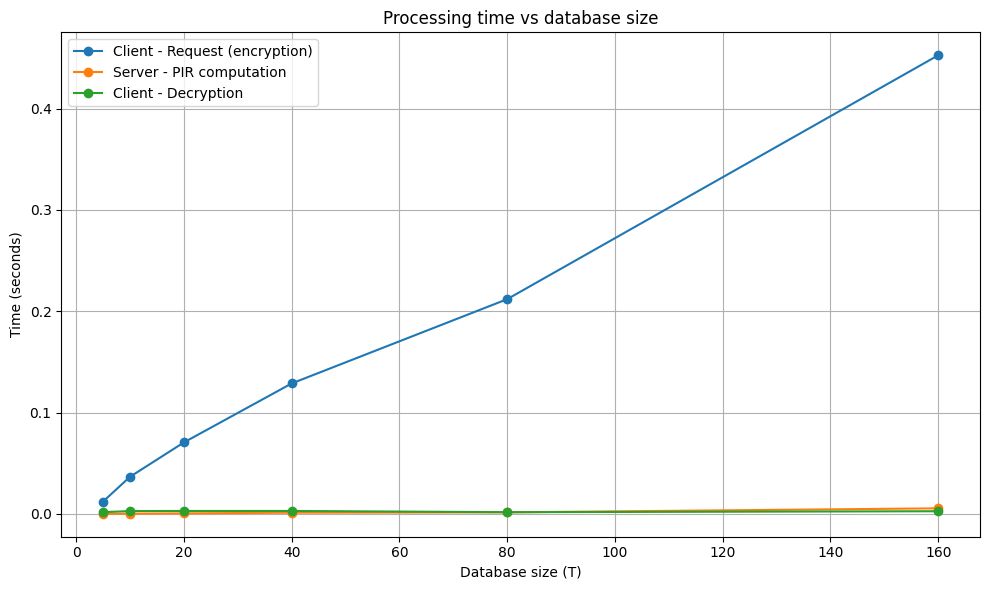

In [ ]:
import time
import matplotlib.pyplot as plt

sizes = [5, 10, 20, 40, 80, 160]
client_encrypt_times = []
server_compute_times = []
client_decrypt_times = []

for size in sizes:
    T = [i * 3 for i in range(size)]
    index = size // 2
    client = Client(bits=512)

    # Measure encryption time (client-side)
    t1 = time.time()
    v = client.request(index, size)
    t2 = time.time()
    client_encrypt_times.append(t2 - t1)

    server = Server(T)

    # Measure PIR computation time (server-side)
    t3 = time.time()
    answer = server.answerRequest(v, client.pk)
    t4 = time.time()
    server_compute_times.append(t4 - t3)

    # Measure decryption time (client-side)
    t5 = time.time()
    result = client.decryptAnswer(answer)
    t6 = time.time()
    client_decrypt_times.append(t6 - t5)

plt.figure(figsize=(10, 6))
plt.plot(sizes, client_encrypt_times, label="Client - Request (encryption)", marker="o")
plt.plot(sizes, server_compute_times, label="Server - PIR computation", marker="o")
plt.plot(sizes, client_decrypt_times, label="Client - Decryption", marker="o")

plt.xlabel("Database size (T)")
plt.ylabel("Time (seconds)")
plt.title("Processing time vs database size")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Client request generation increases linearly with the size of the database T.
This is expected, since the client encrypts a full vector of size n, with one ciphertext per entry.

Server computation time remains almost constant.
Even though the server receives a vector of size n, it effectively performs a single meaningful homomorphic operation, due to all elements but one being encryptions of 0.

Client decryption is also constant, as the client decrypts only one ciphertext Enc(T[i]).

This shows that the computational cost is mostly on the client side, especially during query construction.

### 7.  Compute the size of the communications in bits from the client to the server and from the server to the client, for a fixed number of bits for the paillier scheme

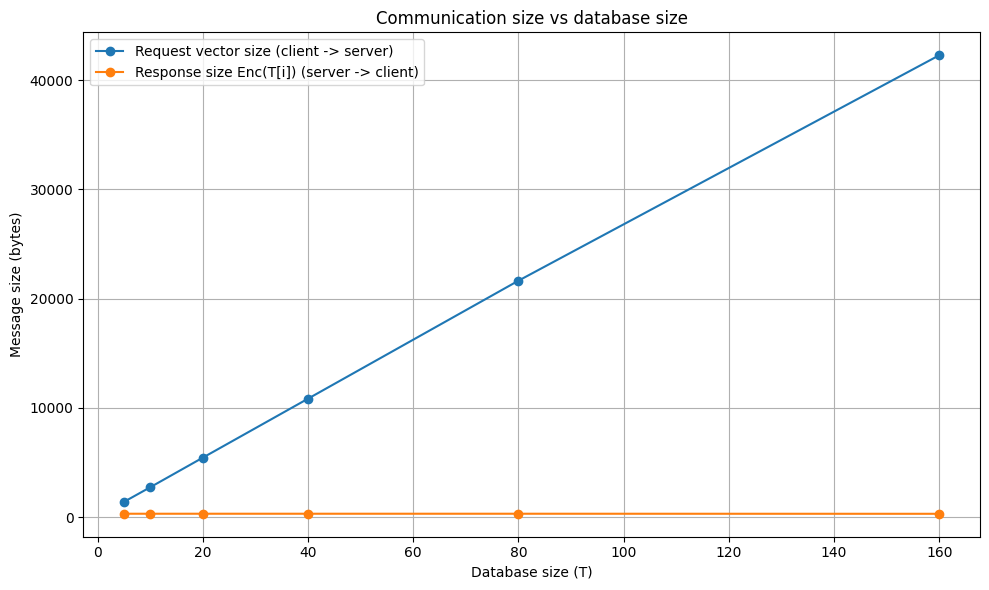

In [ ]:
import sys
import pickle

sizes = [5, 10, 20, 40, 80, 160]
vector_sizes = []
response_sizes = []

for size in sizes:
    T = [i for i in range(size)]
    index = size // 2
    client = Client(bits=512)
    v = client.request(index, size)
    server = Server(T)
    answer = server.answerRequest(v, client.pk)

    # Serialize the request vector and response to measure communication size
    vector_serialized = pickle.dumps(v)
    vector_sizes.append(len(vector_serialized))

    response_serialized = pickle.dumps(answer)
    response_sizes.append(len(response_serialized))

plt.figure(figsize=(10, 6))
plt.plot(sizes, vector_sizes, label="Request vector size (client -> server)", marker="o")
plt.plot(sizes, response_sizes, label="Response size Enc(T[i]) (server -> client)", marker="o")
plt.xlabel("Database size (T)")
plt.ylabel("Message size (bytes)")
plt.title("Communication size vs database size")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We evaluated the communication cost of the PIR protocol:

The size of the vector v increases linearly with the database size n, as it contains one ciphertext per entry. Each Paillier ciphertext is large.

The server response remains constant in size, regardless of the database.
This highlights a major limitation: the upload bandwidth required by the client grows with the database, while the server’s response is minimal.
In large-scale databases, this asymmetry makes the protocol less practical on the client side.


### 8.  What are the memory and efficiency drawbacks of this PIR method ?

While the PIR protocol based on the Paillier cryptosystem ensures strong privacy for the client, it also presents some practical limitations.

Computational Cost
The client must encrypt a full vector of size n, which involves n expensive public-key encryption operations. This step is computationally heavy and becomes slower as the database size increases.

Communication Overhead
The size of the query sent by the client grows linearly with the size of the database. Each element of the query vector is a Paillier ciphertext, which can be large in size. This results in high bandwidth usage for the client. On the other hand, the server only sends back one ciphertext, which is small and constant in size.

Efficiency Issues
This asymmetry in computation and communication makes the protocol less efficient and not easily scalable to large databases. While the privacy guarantees are strong, the cost in terms of time and data makes it impractical for very large datasets.

Conclusion
The Paillier-based PIR protocol is suitable for small databases or situations where privacy is more important than performance. For larger applications, more efficient PIR schemes should be considered.
